# Classify sentences as simple/complex

# Import Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score,precision_recall_curve, classification_report,roc_curve

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

import os

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
# text preprocessing lib
import nltk
# Step 1: word_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
# Step 2: stop_words removal
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
#Step 3: stemming
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Read data

In [5]:
current_directory = os.getcwd()

In [7]:
train = pd.read_csv(current_directory+'/train.csv')

In [8]:
X = train['inc_clean']
y = train['complex']

In [9]:
train.complex.value_counts()

0    290
1     75
Name: complex, dtype: int64

#Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, stratify=y, random_state=42)

# Text - Preprocess

In [11]:
def text_preprocessor(text):
  return [SnowballStemmer(language='english').stem(word) for word in word_tokenize(text) if word not in stopwords]

convert to tf-idf vectors

In [12]:
vectorizer = TfidfVectorizer(lowercase=True,
                             tokenizer=text_preprocessor,
                             max_features=1000)

In [13]:
vectorizer.fit(X_train.values)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(max_features=1000,
                tokenizer=<function text_preprocessor at 0x7d3224dc1e10>)

In [14]:
%%time
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

CPU times: user 195 ms, sys: 3.97 ms, total: 199 ms
Wall time: 205 ms


In [15]:
vectorizer.get_feature_names_out()

array(['%', "'s", '(', ')', '*', '+', '+100', ',', '-', '.', '/', '/=',
       '/=500', '/=750', '/aspart', '/li', '/ol', '/p', '/ul', '0', '0-1',
       '0-2', '0-3', '0.01', '0.5', '0.7×10^9/l', '1', '1+', '1,000/μl',
       '1.0', '1.5', '1.5×upper', '1.6mmol/l', '1.7', '10', '100,000',
       '1000/ul', '10^3/ul', '10^9/l', '12', '12-month', '12.5', '13',
       '14', '15', '1500', '16', '16-65', '18', '18-70', '18-75', '1a',
       '2', '2+', '2.0', '2.0mg/dl', '2.5', '2.5-fold', '2.5mg/dl',
       '2.8g/dl', '20', '2000/dl', '2008', '2016', '20kg', '21', '24',
       '25', '25,000/microlit', '250', '2500c/ml', '26', '28', '2x', '3',
       '3+', '30', '34.2', '3cm', '3month', '3x', '4', '40', '45', '5',
       '5/ul', '50', '500', '50×10^9/l', '56', '5×upper', '6', '6-', '6.',
       '6.5mg/dl', '60', '65', '7', '7.0', '70', '72', '75', '75,000/μl',
       '8', '8.0', '80', '9', '9.0g/dl', '90', '91', ':', ';', '<', '=',
       '=0.4', '=12', '=60', '>', '[', ']', '^', 'a.', 'abi

# Visualizing the Training Data

In [16]:
# Cosine Similarity Matrix
similarity_matrix = cosine_similarity(X_train)
dissimilarity_matrix = 1 - similarity_matrix
#dissimilarity_matrix

In [17]:
# MDS
mds = MDS(n_components=2,normalized_stress='auto', dissimilarity='precomputed')
X_2d = mds.fit_transform(dissimilarity_matrix)

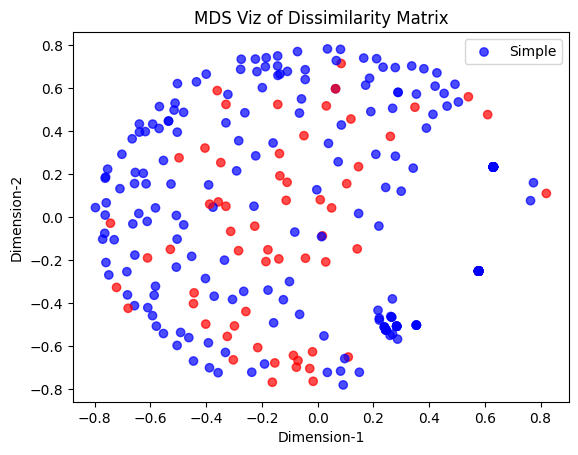

In [18]:
color_mapping = {0.0: 'blue', 1.0: 'red'}
colors = [color_mapping[v] for v in y_train]

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.7)
plt.title('MDS Viz of Dissimilarity Matrix')
plt.xlabel('Dimension-1')
plt.ylabel('Dimension-2')
plt.legend(['Simple','Complex'])
plt.show();

In [21]:
def get_metrics(y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  auroc = roc_auc_score(y_test, y_pred)

  print(classification_report(y_test, y_pred))

  print("AUROC:", auroc)

# Logit Model

In [19]:
clf = LogisticRegression(max_iter = 200, solver='liblinear',class_weight='balanced' ).fit(X_train, y_train)

In [22]:
get_metrics(clf.predict(X_test))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86        58
           1       0.50      0.87      0.63        15

    accuracy                           0.79        73
   macro avg       0.73      0.82      0.75        73
weighted avg       0.86      0.79      0.81        73

AUROC: 0.821264367816092


# Hypertuned Random Forest Classifier

In [23]:
class_weight = []
for x in np.arange(1,5.0,0.5):
    class_weight.append({0:1,1:x})

# parameter grid to search over
param_grid = {
    'n_estimators': [75], # no of trees
    'max_depth': [2],
    'min_samples_split': [4],
    'min_samples_leaf': [6],
    'max_features': ['sqrt'], #'log2'
    'bootstrap':[False],
    'class_weight': [{0: 1, 1: 3.5}], #class_weight,
    'criterion':['gini'],#'entropy'
}
# RandomForest model
rf = RandomForestClassifier(random_state=42)
#GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=2,)
# fit the data to grid search
grid_search.fit(X_train, y_train)
# get the best estimator
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [24]:
grid_search.best_params_

{'bootstrap': False,
 'class_weight': {0: 1, 1: 3.5},
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 4,
 'n_estimators': 75}

In [25]:
get_metrics(best_rf.predict(X_test))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88        58
           1       0.56      0.67      0.61        15

    accuracy                           0.82        73
   macro avg       0.73      0.76      0.75        73
weighted avg       0.84      0.82      0.83        73

AUROC: 0.7643678160919538


RandomOverSampler

In [26]:
from imblearn.over_sampling import RandomOverSampler

In [27]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

# Hypertuned Gradient Boosting Classifier

In [28]:
param_grid = {
    'n_estimators': [85],
    'learning_rate': [0.04] , #np.arange(0.01,0.05),
    'max_depth': [6],
    'min_samples_split': [4],
    'min_samples_leaf': [4],
    'subsample': [0.7],
}
class_weights = dict(zip(*np.unique(y_resampled, return_counts=True)))
sample_weights = [class_weights[label] for label in y_resampled]

gb_model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, n_jobs=-1,cv=5, scoring='roc_auc') #verbose=2,

grid_search.fit(X_resampled, y_resampled,sample_weight=sample_weights)

best_gb = grid_search.best_estimator_

In [29]:
grid_search.best_params_

{'learning_rate': 0.04,
 'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 85,
 'subsample': 0.7}

In [30]:
get_metrics(best_gb.predict(X_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.86        58
           1       0.50      0.67      0.57        15

    accuracy                           0.79        73
   macro avg       0.70      0.75      0.72        73
weighted avg       0.82      0.79      0.80        73

AUROC: 0.7471264367816092


# KNN

In [31]:
param_grid = {
    'n_neighbors': [35],
    'weights': ['distance',],
    'metric':['euclidean','minkowski'],
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='roc_auc', n_jobs=-1,cv=5, verbose=2)
grid_search.fit(X_resampled, y_resampled)

best_knn = grid_search.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [32]:
grid_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 35, 'weights': 'distance'}

In [33]:
get_metrics(best_knn.predict(X_test))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81        58
           1       0.44      0.93      0.60        15

    accuracy                           0.74        73
   macro avg       0.71      0.81      0.70        73
weighted avg       0.87      0.74      0.76        73

AUROC: 0.8114942528735634


# SVM

In [34]:
from sklearn.svm import SVC

In [35]:
param_grid = {
    'C': [2],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale'],
    'class_weight' : ['balanced'],
}
svm = SVC(probability=True)

grid_search = GridSearchCV(estimator=svm,param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

In [36]:
grid_search.best_params_

{'C': 2, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}

In [37]:
get_metrics(best_svm.predict(X_test))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81        58
           1       0.44      0.93      0.60        15

    accuracy                           0.74        73
   macro avg       0.71      0.81      0.70        73
weighted avg       0.87      0.74      0.76        73

AUROC: 0.8114942528735634


#Voting Classifier

In [38]:
from itertools import combinations

In [39]:
def generate_combinations(items):
  all_combos = []
  for r in range(2, 6):
    combos = combinations(items, r)
    all_combos.extend(combos)
  return all_combos

ensembles = generate_combinations([('logit', clf),('svm',svm),('rf', best_rf), ('gb', best_gb), ('knn', best_knn)])
#ensembles[0]


score = 0.8


for estimators in ensembles:

  ensemble = [tuple(item) for item in estimators]

  voting_clf = VotingClassifier(estimators=ensemble,voting='soft') #averaging on predict_probabilities
  voting_clf = voting_clf.fit(X_train, y_train)

  ensemble_predictions = voting_clf.predict(X_test)
  #ensemble_probabilities = voting_clf.predict_proba(X_test)[:, 0]

  if score < max(score,roc_auc_score(y_test, ensemble_predictions)):
    print([tuple(item)[0] for item in estimators])
    get_metrics(ensemble_predictions)
    print('..................................................................................')


['logit', 'rf']
              precision    recall  f1-score   support

           0       0.96      0.79      0.87        58
           1       0.52      0.87      0.65        15

    accuracy                           0.81        73
   macro avg       0.74      0.83      0.76        73
weighted avg       0.87      0.81      0.82        73

AUROC: 0.8298850574712644
..................................................................................
['svm', 'gb']
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        58
           1       0.77      0.67      0.71        15

    accuracy                           0.89        73
   macro avg       0.84      0.81      0.82        73
weighted avg       0.89      0.89      0.89        73

AUROC: 0.807471264367816
..................................................................................
['logit', 'svm', 'gb']
              precision    recall  f1-score   support

           0       0.

In [42]:
best_voting_clf = VotingClassifier(estimators=[('logit', clf),('svm',best_svm),('rf', best_rf), ('gb', best_gb)],voting='soft') #averaging on predict_probabilities
best_voting_clf = best_voting_clf.fit(X_train, y_train)

ensemble_predictions = best_voting_clf.predict(X_test)
#ensemble_probabilities = voting_clf.predict_proba(X_test)[:, 0]

get_metrics(ensemble_predictions)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        58
           1       0.73      0.73      0.73        15

    accuracy                           0.89        73
   macro avg       0.83      0.83      0.83        73
weighted avg       0.89      0.89      0.89        73

AUROC: 0.8321839080459771


# CV fold

In [43]:
from sklearn.model_selection import cross_val_score

In [47]:
for name,model in [('logit',clf),('RF',best_rf),('GB',best_gb),('KNN',best_knn),('svm',best_svm),('ensembled_model',best_voting_clf)]:

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cv_scores = cross_val_score(model, vectorizer.transform(X), y, cv=cv, scoring='roc_auc')

  mean_cv = cv_scores.mean()
  se_cv = cv_scores.std()/np.sqrt(len(cv_scores))
  var_cv = se_cv ** 2
  print('Model:',name)
  print(f"CV scores: {cv_scores} ")
  print(f"Mean: {mean_cv:.2f}")
  print(f"Standard Error: {se_cv:.2f}")
  #print(f"Variance: {var_cv:.5f}")
  print('...........................')

Model: logit
CV scores: [0.80229885 0.85747126 0.84425287 0.87126437 0.87701149] 
Mean: 0.85
Standard Error: 0.01
...........................
Model: RF
CV scores: [0.81954023 0.87701149 0.81206897 0.92413793 0.91781609] 
Mean: 0.87
Standard Error: 0.02
...........................
Model: GB
CV scores: [0.79655172 0.85862069 0.80517241 0.9091954  0.8637931 ] 
Mean: 0.85
Standard Error: 0.02
...........................
Model: KNN
CV scores: [0.71609195 0.72586207 0.76954023 0.85402299 0.80229885] 
Mean: 0.77
Standard Error: 0.02
...........................
Model: svm
CV scores: [0.79770115 0.85287356 0.81666667 0.85977011 0.87471264] 
Mean: 0.84
Standard Error: 0.01
...........................
Model: ensembled_model
CV scores: [0.7908046  0.86091954 0.8316092  0.88390805 0.89655172] 
Mean: 0.85
Standard Error: 0.02
...........................


# Optimum classification threshold

In [53]:
thresholds = np.arange(0.26, 0.27, 0.01)

# FOR CLASS 0 : SIMPLE

best_f1_score = 0
best_precision_score = 0.99
best_recall_score = 0
best_threshold = 0.0

pred_probab = best_voting_clf.predict_proba(X_test)[:, 1]

for threshold in thresholds:
  # making binary preds acc to current threshold
  new_preds = [1 if prob >= threshold else 0 for prob in pred_probab]

  #print(new_preds)
  #print([int(y) for y in y_test])
  precision = precision_score([int(y) for y in y_test], new_preds, pos_label=0, average='binary')
  recall = recall_score([int(y) for y in y_test], new_preds, pos_label=0, average='binary')
  f1 = f1_score([int(y) for y in y_test], new_preds, pos_label=0, average='binary')

  #if precision>=0.99:# and f1>0.8:
  print('at',threshold)
  get_metrics(new_preds)
  print("F1 :",f1)
  print(".............")

  # Check if this threshold gives a better F1 score
  if precision >= best_precision_score:
      best_f1_score = f1
      best_threshold = threshold
      best_precision_score = precision

print(f"Best F1 Score: {best_f1_score:.2f}, precision is {best_precision_score:.2f} at Threshold: {best_threshold:.2f}")

at 0.26
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        58
           1       0.42      1.00      0.59        15

    accuracy                           0.71        73
   macro avg       0.71      0.82      0.68        73
weighted avg       0.88      0.71      0.74        73

AUROC: 0.8189655172413793
F1 : 0.7789473684210527
.............
at 0.27
              precision    recall  f1-score   support

           0       0.97      0.67      0.80        58
           1       0.42      0.93      0.58        15

    accuracy                           0.73        73
   macro avg       0.70      0.80      0.69        73
weighted avg       0.86      0.73      0.75        73

AUROC: 0.8028735632183908
F1 : 0.7959183673469388
.............
Best F1 Score: 0.78, precision is 1.00 at Threshold: 0.26


### youden_index

summarizes the performance of a binary classification test


```
youden_index = Sensitivity+Specificity−1

tpr = Sensitivity
Specificity = tnr = TN/FP+TN
fpr = 1-Specificity = FP/FP+TN
```

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, pred_probab)

In [55]:
youden_index = tpr - fpr

In [60]:
thresholds[np.argmax(youden_index)],youden_index

(0.4889575660405413,
 array([0.        , 0.06666667, 0.26666667, 0.24942529, 0.38275862,
        0.34827586, 0.54827586, 0.53103448, 0.73103448, 0.62758621,
        0.69425287, 0.62528736, 0.69195402, 0.58850575, 0.65517241,
        0.56896552, 0.53448276, 0.5       , 0.46551724, 0.37931034,
        0.29310345, 0.25862069, 0.12068966, 0.0862069 , 0.        ]))

the threshold that maximizes the Youden Index is 0.20155362000830934 and F1 Score(0) at this point is 0.88

check stopwords set, so that we are not removing something that is valauable

# Save Model

In [93]:
# class CustomThresholdVotingClassifier(VotingClassifier):
#   def __init__(self, estimators, voting='soft', threshold=0.5):
#     super().__init__(estimators, voting=voting)
#     self.threshold = threshold

#   def predict(self, X):
#     # predicted probabilities from each clf
#     probas = np.column_stack([estimator.predict_proba(X)[:, 1] for estimator in self.estimators])
#     # average probability for each
#     avg_proba = np.mean(probas, axis=1)
#     # on custom threshold
#     predictions = (avg_proba >= self.threshold).astype(int)
#     return predictions

# # Voting Clf with custom threshold
# custom_threshold_voting_clf = CustomThresholdVotingClassifier(estimators=[best_voting_clf], threshold=0.26)

# get_metrics(custom_threshold_voting_clf.predict(X_test))

In [62]:
from joblib import dump

In [94]:
dump(best_voting_clf, 'sc_v1.joblib')

['sc_v1.joblib']

In [97]:
dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

# Predict

In [96]:
new_text = ['Patients with relapsed or refractory advanced solid malignancies (diagnosed by histology or cytology detection).	',
            'PS score 0-2, KPS score ≥60;',
            'Accepts Healthy Volunteers: No	',
            'Estimated life expectancy > 12 weeks deemed by investigator',
            'There is no active pulmonary infection, and the oxygen saturation during air inhalation is more than 92%;	',
            '<p>B-cell ALL</p><ul>\n<li>\n<p>Relapsed disease that is CD123 positive and CD19 negative/dim or patients otherwise ineligible for CD19 directed therapies including</p>\n<ul>\n<li>Patients in 2nd or greater relapse</li>\n<li>Patients with relapse after allogeneic HSCT</li>\n</ul>\n</li>\n<li>Refractory disease that is CD123 positive and CD19 negative/dim or patients otherwise ineligible for CD19 directed therapies</li>\n</ul>']
new_text_tfidf = vectorizer.transform(new_text)
predictions = best_voting_clf.predict(new_text_tfidf)
predictions

array([0, 0, 0, 0, 1, 1])